In [2935]:
import pandas as pd
import tensorflow as tf
from numpy import dtype
from tensorflow.keras.layers import TextVectorization, Embedding
from keras.src.layers import Dense, Dropout
from keras.src.layers import concatenate

In [2936]:
salaries_data = pd.read_csv("data/ds_salaries_cleaned.csv")
salaries_data = salaries_data.sample(frac=1)
salaries_data.head()

,work_year,experience_level,employment_type,job_title,remote_ratio,residence_gdp_per_capita,company_gdp_per_capita,company_size,salary_in_usd
592,2023,EN,FT,Business Data Analyst,0,33895.593,33895.593,M,21461.0
83,2021,EN,FT,Data Science Consultant,0,52300.607,52300.607,L,76833.0
4,2020,EN,FT,Data Analyst,100,2099.135,2099.135,S,10000.0
162,2021,MI,FT,Data Scientist,100,2250.179,2250.179,S,16904.0
61,2020,SE,FT,Data Scientist,100,17570.395,64461.618,L,68428.0


In [2937]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [2938]:
years_mapping = {
    "2020": 1,
    "2021": 2,
    "2022": 3,
    "2023": 4,
}
years_encoded = salaries_data["work_year"].apply(lambda x: years_mapping[str(x)])
salaries_data["work_year"] = years_encoded

In [2939]:
experience_levels_mapping = {
    "EN": 1,
    "MI": 2,
    "SE": 3,
    "EX": 4
}
experience_levels_encoded = salaries_data["experience_level"].apply(lambda x: experience_levels_mapping[str(x)])
salaries_data["experience_level"] = experience_levels_encoded

In [2940]:
employment_type_mapping = {
    "PT": 1,
    "FL": 2,
    "CT": 3,
    "FT": 4
}
employment_type_encoded = salaries_data["employment_type"].apply(lambda x: employment_type_mapping[str(x)])
salaries_data["employment_type"] = employment_type_encoded

In [2941]:
remote_ratio_mapping = {
    "0": 1,
    "50": 2,
    "100": 3
}
remote_ratio_encoded = salaries_data["remote_ratio"].apply(lambda x: remote_ratio_mapping[str(x)])
salaries_data["remote_ratio"] = remote_ratio_encoded

In [ ]:
company_size_mapping = {
    "S": 1,
    "M": 2,
    "L": 3
}
company_size_encoded = salaries_data["company_size"].apply(lambda x: company_size_mapping[str(x)])
salaries_data["company_size"] = company_size_encoded

In [ ]:
salaries_data["residence_gdp_per_capita"] = normalize(salaries_data["residence_gdp_per_capita"])
salaries_data["company_gdp_per_capita"] = normalize(salaries_data["company_gdp_per_capita"])
salaries_data["experience_level"] = normalize(salaries_data["experience_level"])
salaries_data["employment_type"] = normalize(salaries_data["employment_type"])
salaries_data["work_year"] = normalize(salaries_data["work_year"])
salaries_data["remote_ratio"] = normalize(salaries_data["remote_ratio"])
salaries_data["company_size"] = normalize(salaries_data["company_size"])

In [2944]:
salaries_data

,work_year,experience_level,employment_type,job_title,remote_ratio,residence_gdp_per_capita,company_gdp_per_capita,company_size,salary_in_usd
592,1.000000,0.000000,1.0,Business Data Analyst,0.0,0.248374,0.248374,0.5,21461.0
83,0.333333,0.000000,1.0,Data Science Consultant,0.0,0.385301,0.385301,1.0,76833.0
4,0.000000,0.000000,1.0,Data Analyst,1.0,0.011818,0.011818,0.0,10000.0
162,0.333333,0.333333,1.0,Data Scientist,1.0,0.012942,0.012942,0.0,16904.0
61,0.000000,0.666667,1.0,Data Scientist,1.0,0.126920,0.475775,1.0,68428.0
...,...,...,...,...,...,...,...,...,...
28,0.000000,0.333333,1.0,Data Analyst,1.0,0.475775,0.475775,1.0,85000.0
43,0.000000,0.333333,1.0,Data Scientist,1.0,0.295504,0.295504,0.0,76958.0
706,1.000000,0.333333,1.0,Research Engineer,1.0,0.611575,0.611575,0.5,110000.0
296,0.666667,0.000000,1.0,Data Scientist,0.0,0.576347,0.576347,1.0,82000.0


In [2945]:
import matplotlib.pyplot as plt

numerical = salaries_data.drop("job_title", axis=1)
numerical.corr()["salary_in_usd"]


work_year                   0.200134
experience_level            0.485009
employment_type             0.162925
remote_ratio               -0.084715
residence_gdp_per_capita    0.655164
company_gdp_per_capita      0.628952
company_size                0.061793
salary_in_usd               1.000000
Name: salary_in_usd, dtype: float64

In [2946]:
from keras.src.layers import GlobalAveragePooling1D
from keras import Input

vectorize_layer = TextVectorization(
    max_tokens=1000, 
    output_mode='int',
    standardize="lower_and_strip_punctuation",
    output_sequence_length=5 
)
vectorize_layer.adapt(salaries_data['job_title'].values)

embedding_dim = 1
embedding_layer = Embedding(
    input_dim=100,
    output_dim=embedding_dim
)

# Vectorize and embed the job titles
job_title_input = Input(shape=(1,), dtype=tf.string, name='job_title')
job_title_vectorized = vectorize_layer(job_title_input)
job_title_embedded = embedding_layer(job_title_vectorized)
job_title_branch = GlobalAveragePooling1D()(job_title_embedded)

In [2947]:
company_gdp_input = Input(shape=(1,), dtype=tf.float64, name="company_gdp")
residence_gdp_input = Input(shape=(1,), dtype=tf.float64, name="residence_gdp")
experience_level_input = Input(shape=(1,), dtype=tf.float64, name="experience_level")
employment_type_input = Input(shape=(1,), dtype=tf.float64, name="employment_type")
work_year_input = Input(shape=(1,), dtype=tf.float64, name="work_year")
company_size_input = Input(shape=(1,), dtype=tf.float64, name="company_size")
remote_ratio_input = Input(shape=(1,), dtype=tf.float64, name="remote_ratio")

# inputs = [company_gdp_input, residence_gdp_input, experience_level_input, employment_type_input, work_year_input, company_size_input, remote_ratio_input]
# include_job_title = True

In [2948]:
# from keras.src.layers import concatenate
# 
# preprocessed_layers = []
# for input_layer in inputs:
#     preprocessed_layers.append(input_layer)
# 
# if include_job_title:
#     preprocessed_layers.append(job_title_branch)
# 
# concatenated = concatenate(preprocessed_layers)

In [2949]:
# hidden_layer_1 = Dense(256, activation='relu')(concatenated)
# dropout_1 = Dropout(0.5)(hidden_layer_1)
# hidden_layer_2 = Dense(256, activation='relu')(dropout_1)
# dropout_2 = Dropout(0.5)(hidden_layer_2)
# hidden_layer_3 = Dense(256, activation='relu')(dropout_2)

In [2950]:
# output = Dense(1, activation=None)(hidden_layer_3)

In [2951]:
# input_layers = []
# for input_layer in inputs:
#     input_layers.append(input_layer)
# 
# if include_job_title:
#     input_layers.append(job_title_input)
# 
# model = tf.keras.Model(inputs=input_layers, outputs=output)

In [2952]:
# model.summary()

In [2953]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
# model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError, metrics=[tf.keras.metrics.RootMeanSquaredError])

In [2954]:
from keras.src.regularizers import regularizers

def build_model():
    inputs = [company_gdp_input, residence_gdp_input, experience_level_input, work_year_input, company_size_input, remote_ratio_input]
    include_job_title = True

    preprocessed_layers = []
    for input_layer in inputs:
        preprocessed_layers.append(input_layer)
    
    if include_job_title:
        preprocessed_layers.append(job_title_branch)

    concatenated = concatenate(preprocessed_layers)

    input_layers = []
    for input_layer in inputs:
        input_layers.append(input_layer)
    
    if include_job_title:
        input_layers.append(job_title_input)
    
    regularizer = regularizers.L1L2(l1=0.01, l2=0.01)
    
    hidden_layer_1 = Dense(256, activation='relu', kernel_regularizer=regularizer)(concatenated)
    dropout_1 = Dropout(0.5)(hidden_layer_1)
    hidden_layer_2 = Dense(128, activation='relu', kernel_regularizer=regularizer)(dropout_1)
    dropout_2 = Dropout(0.5)(hidden_layer_2)
    hidden_layer_3 = Dense(64, activation='relu', kernel_regularizer=regularizer)(dropout_2)
    output = Dense(1, activation=None)(hidden_layer_3)
    
    model = tf.keras.Model(inputs=input_layers, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError, metrics=[tf.keras.metrics.RootMeanSquaredError])
    return model
    


In [2955]:
import numpy as np
from sklearn.model_selection import KFold

def k_fold_cross_validation(model_builder, df, epochs, batch_size, k=5):    
    kf = KFold(n_splits=k, shuffle=True)
    validation_accuracies = []

    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f"Fold {fold + 1}/{k}")
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        train_work_year = train_df["work_year"]
        train_experience_level = train_df["experience_level"]
        train_employment_type = train_df["employment_type"]
        train_job_title = train_df["job_title"].values
        train_remote_ratio = train_df["remote_ratio"]
        train_residence_gdp_per_capita = train_df["residence_gdp_per_capita"]
        train_company_gdp = train_df["company_gdp_per_capita"]
        train_company_size = train_df["company_size"]
        train_salary = train_df["salary_in_usd"].values
        
        val_work_year = val_df["work_year"]
        val_experience_level = val_df["experience_level"]
        val_employment_type = val_df["employment_type"]
        val_job_title = val_df["job_title"].values
        val_remote_ratio = val_df["remote_ratio"]
        val_residence_gdp_per_capita = val_df["residence_gdp_per_capita"]
        val_company_gdp = val_df["company_gdp_per_capita"]
        val_company_size = val_df["company_size"]
        val_salary = val_df["salary_in_usd"]
        
        model = model_builder()

        history = model.fit({
            "work_year": train_work_year,
            "experience_level": train_experience_level,
            "employment_type": train_employment_type,
            "job_title": train_job_title,
            "remote_ratio": train_remote_ratio,
            "residence_gdp": train_residence_gdp_per_capita,
            "company_size": train_company_size,
            "company_gdp": train_company_gdp,
        }, train_salary, epochs=epochs, batch_size=batch_size, 
            validation_data=({
                "work_year": val_work_year,
                "experience_level": val_experience_level,
                "employment_type": val_employment_type,
                "job_title": val_job_title,
                "remote_ratio": val_remote_ratio,
                "residence_gdp": val_residence_gdp_per_capita,
                "company_size": val_company_size,
                "company_gdp": val_company_gdp,
            }, val_salary), verbose=0)

        # Evaluate the model on the validation set
        _, val_accuracy = model.evaluate({
            "work_year": val_work_year,
            "experience_level": val_experience_level,
            "employment_type": val_employment_type,
            "job_title": val_job_title,
            "remote_ratio": val_remote_ratio,
            "residence_gdp": val_residence_gdp_per_capita,
            "company_size": val_company_size,
            "company_gdp": val_company_gdp,
        }, val_salary, verbose=0)
        validation_accuracies.append(val_accuracy)
        
        result = pd.DataFrame(history.history)
        
        result[["root_mean_squared_error", "val_root_mean_squared_error"]].plot(figsize=(5,3))
        plt.show()

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("-" * 20)

    print(f"Average Validation Accuracy: {np.mean(validation_accuracies):.4f}")
    return validation_accuracies

Fold 1/5


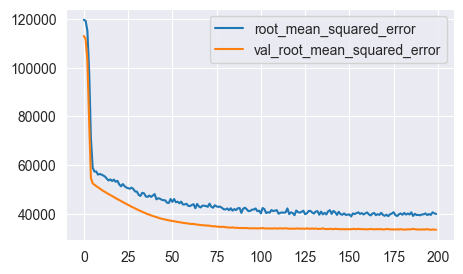

Validation Accuracy: 33369.4766
--------------------
Fold 2/5


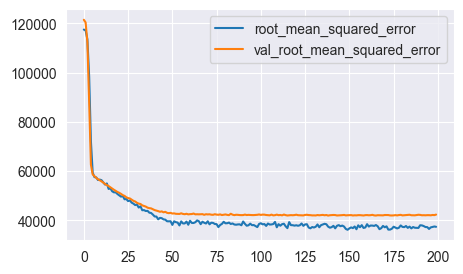

Validation Accuracy: 42316.4141
--------------------
Fold 3/5


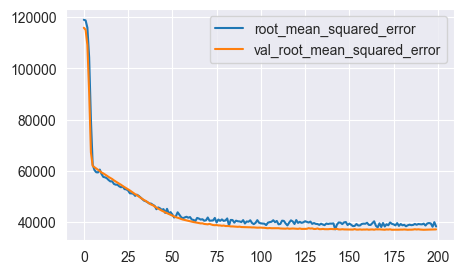

Validation Accuracy: 37216.2695
--------------------
Fold 4/5


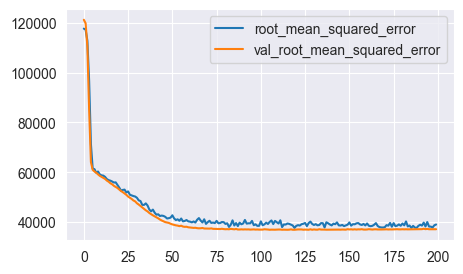

Validation Accuracy: 37191.7930
--------------------
Fold 5/5


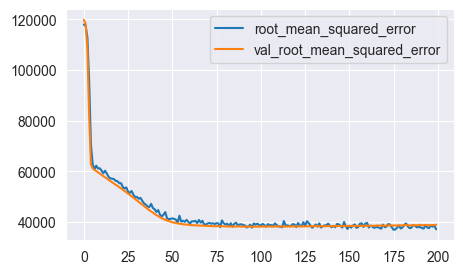

Validation Accuracy: 38903.9609
--------------------
Average Validation Accuracy: 37799.5828


[33369.4765625, 42316.4140625, 37216.26953125, 37191.79296875, 38903.9609375]

In [2956]:
k_fold_cross_validation(build_model, salaries_data, epochs=200, batch_size=8)